In [540]:
import numpy as np
import matplotlib.pyplot as plt

# 2: Problem Formulation

"We consider the special case where r is constant. (What if r is not constant?)
The problem is then to compute
$$
\frac{V_{t_0}(S_{t_0})}{B_{t_0}} = \max_{\tau}(\mathbb{E}\frac{h(S_\tau)}{B_\tau})."
$$

In [541]:
from DiscretizationSchemes import discretizationScheme, StockpriceGBM # consider different discretization schemes?
from intrinsicOptionValues import call, put # consider more payoffs?


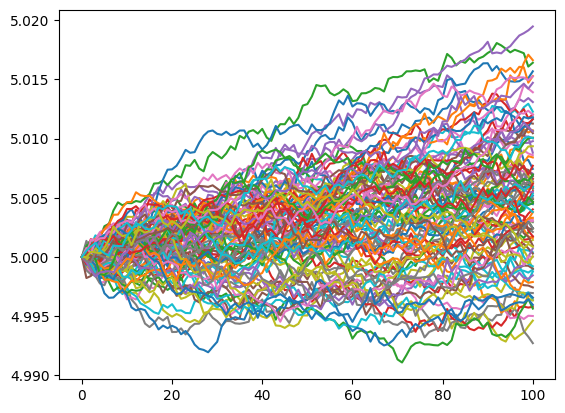

In [542]:
# check discretizationscheme
mu = 0.001
sigma = 0.01
start_price = 5
times = np.linspace(0,1,101) # monitoring dates
N = 100
for i in range(N):
    plt.plot(discretizationScheme(times, start_price, mu, sigma))

### Lokeshwar, p4: Optimization problem (1)

In [543]:
from scipy import optimize

In [544]:
# compute for a call with strike K=5
K = 100
def h(S_T):
    return call(S_T,K)

# "Generate Stm (n) for paths n = 1,...,N, m = 0,...,M" (option price should not depend on mu?)
S0, mu, sigma = 100, 0.09, 0.3
r = 0.05 # constant risk free rate
T=1
M = 52
monitoring_dates = np.linspace(0,T,M) # does not have to be evenly spaced
N = 100
sampleS = []
for i in range(N):
    sampleS.append(discretizationScheme(monitoring_dates, S0, mu, sigma))
sampleS = np.matrix(sampleS)

# "Evaluate final time option value for each path."
sampleV = np.zeros_like(sampleS)
for n in range(N):
    S_T = sampleS[n,M-1]
    sampleV[n,M-1] = max(h(S_T),0)

# Initialize βtM from uniform distribution.
d = 1 # in this case the Markovian process is a single stock price
p = 10 # number of neurons, see Hornik et al for a reasonable value
Np = p*d + p + p + 1
betas = np.zeros((M,Np))
betas[M-1] = np.random.uniform(0,1,Np) # ReLU only learns from positive values

def G(beta,S_t):
    A1S_T = S_t * beta[:p] + beta[p:p+p]
    phiA1S_T = np.maximum(A1S_T, np.zeros_like(A1S_T))
    W2 = np.array([beta[p+p:p+p+p]])
    A2phiA1S_T = np.dot(W2,phiA1S_T.transpose()) + beta[p+p+p]
    psiA2phiA1S_T = A2phiA1S_T
    return psiA2phiA1S_T[0] # [0,0]?

def Expectation_G_given_Stminus1(beta,Stminus1,N):
  avgG = 0
  for n in range(N):
    St = StockpriceGBM(1/N, Stminus1, mu, sigma)
    avgG += G(beta, St) / N
  return avgG

def target(beta, S_t, V_t):
    return (1/N) * sum([(V_t[n] - G(beta, S_t[n]))**2 for n in range(N)])

# Regress later
for i in range(M-1, 0, -1):
  print(i)
  # fit the network
  fit = optimize.minimize(target, x0=betas[i,:], args=(sampleS[:,i], sampleV[:,i])) # specify method?
  if fit.success:
      betas[i-1] = fit.x
  else:
      print(fit.message)

  # estimate continuation value Qti(n), get estimated option value Vti(n)
  for n in range(N):
    Btiminus1 = np.exp(-r*T/N)
    Qtiminus1 = Btiminus1 * Expectation_G_given_Stminus1(betas[i-1,:], sampleS[n,i-1], 100)
    if h(sampleS[n,i-1]) > Qtiminus1:
      sampleV[n,i-1] = h(sampleS[n,i-1])
    else:
      sampleV[n,i-1] = Qtiminus1
  
  # initialize parameters for next training
  if i == 1:
    break
  else:
    betas[i-2] = betas[i-1]




51
Desired error not necessarily achieved due to precision loss.
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [545]:
sampleV[n,:]

matrix([[9.6971137 , 9.70196346, 9.70681565, 9.71167027, 9.71652732,
         9.72138679, 9.7262487 , 9.73111303, 9.7359798 , 9.74084901,
         9.74572065, 9.75059472, 9.75547123, 9.76035018, 9.76523158,
         9.77011541, 9.77500168, 9.7798904 , 9.78478157, 9.78967518,
         9.79457124, 9.79946974, 9.8043707 , 9.80927411, 9.81417997,
         9.81908828, 9.82399905, 9.82891227, 9.83382795, 9.83874609,
         9.84366669, 9.84439149, 9.84268082, 9.83285441, 9.81011096,
         9.76284558, 9.70673304, 9.63458441, 9.54514382, 9.43007629,
         9.29821985, 9.13310245, 8.90852572, 8.67019203, 8.40926824,
         8.05390031, 8.00433558, 8.91428898, 8.84846901, 8.617832  ,
         8.57481842, 7.93591682]])

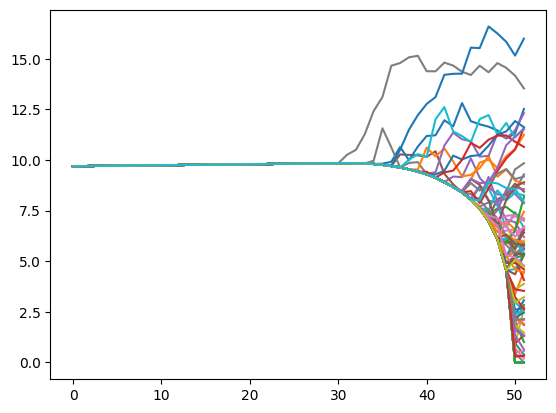

In [546]:
# sampled option paths, for later times t we notice that for OTM options the value occasionally becomes negative,
# this is due to the fact that we choose beta such that the mean squared error over all samples is minimized,
# without the constraint that the approximation of V should be nonnegative.
for n in range(N):
    pathAsRow = sampleV[n,:]
    plt.plot(pathAsRow.transpose())

In [547]:
holdValues = np.zeros(len(times)-1)
